In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import shutil
from tqdm.auto import tqdm

In [2]:
!mkdir -p /root/.config/kaggle

In [3]:
!mv kaggle.json /root/.config/kaggle

In [4]:
import kaggle

In [5]:
!kaggle competitions download -c dogs-vs-cats

 98% 799M/812M [00:02<00:00, 268MB/s]
100% 812M/812M [00:02<00:00, 286MB/s]


In [6]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [7]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [8]:
!mkdir image
!mkdir image/cat
!mkdir image/dog

In [9]:
import os

In [10]:
for i in tqdm(os.listdir("train/")):
  if i.startswith("cat"):
    shutil.copy("train/"+i,"image/cat")
  elif i.startswith("dog"):
    shutil.copy("train/"+i,"image/dog")

  0%|          | 0/25000 [00:00<?, ?it/s]

In [11]:

!mkdir test

In [12]:
test_dog=np.random.choice(os.listdir("image/dog"),500,replace=False)
test_cat=np.random.choice(os.listdir("image/cat"),500,replace=False)

for i in test_dog:
  shutil.move("image/dog/"+i,"test")
for i in test_cat:
  shutil.move("image/cat/"+i,"test")

In [13]:
import tensorflow as tf

In [14]:
idg=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                    horizontal_flip=True,
                                                    vertical_flip=True,
                                                    validation_split=0.1)

In [15]:
batch_size=32

In [16]:
train_idg=idg.flow_from_directory("image",target_size=(150,150),
                                  batch_size=batch_size,
                                  subset="training")

val_idg=idg.flow_from_directory("image",target_size=(150,150),
                                batch_size=batch_size,
                                subset="validation")

Found 21600 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


In [17]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((150,150,3),name="Input Layer"))
#chunk 1
model.add(tf.keras.layers.Conv2D(filters=16,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu",
                                 name="conv1"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                       strides=(2,2),
                                       padding="valid",
                                       name="pool1"))
#chunk 2
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu",
                                 name="conv2"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                       strides=(2,2),
                                       padding="valid",
                                       name="pool2"))
#chunk 3
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu",
                                 name="conv3"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                       strides=(2,2),
                                       padding="valid",
                                       name="pool3"))

model.add(tf.keras.layers.Flatten(name="flat"))
model.add(tf.keras.layers.Dense(128,activation="relu",name="Hidden"))
model.add(tf.keras.layers.Dense(2,activation="softmax",name="output"))

In [18]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 34, 34, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flat (Flatten)                       │ (None, 9248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden (Dense)                       │ (None, 128)                 │       1,183,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,198,466 (4.57 MB)

 Trainable params: 1,198,466 (4.57 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['acc'])

In [20]:
model.fit(train_idg,epochs=10,validation_data=val_idg,batch_size=batch_size)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - acc: 0.5421 - loss: 0.6859 - val_acc: 0.5417 - val_loss: 0.6860
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 46s 68ms/step - acc: 0.6054 - loss: 0.6564 - val_acc: 0.6571 - val_loss: 0.6146
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - acc: 0.6457 - loss: 0.6242 - val_acc: 0.6842 - val_loss: 0.5963
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - acc: 0.6867 - loss: 0.5881 - val_acc: 0.7125 - val_loss: 0.5610
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 88s 86ms/step - acc: 0.7014 - loss: 0.5690 - val_acc: 0.7408 - val_loss: 0.5425
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - acc: 0.7160 - loss: 0.5511 - val_acc: 0.7029 - val_loss: 0.5646
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 89s 88ms/step - acc: 0.7140 - loss: 0.5459 - val_acc: 0.6942 - val_loss: 0.5663
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 88s 97ms/step - acc: 0.7237 - loss: 0.5367 - val_acc: 0.7475 - val_loss: 0.5195
Epoch 9/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/st

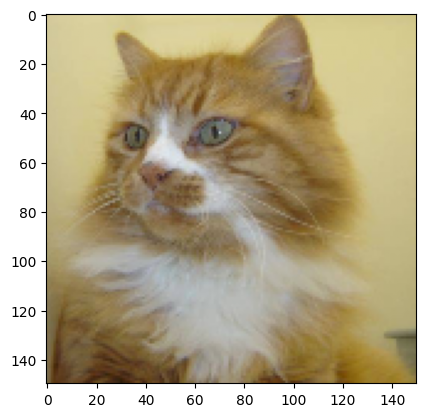

In [27]:
test_image="/content/test/cat.10009.jpg"
test_image=cv2.imread(test_image)
test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
test_image=cv2.resize(test_image,(150,150))
test_image=test_image/255.0
plt.imshow(test_image)
test_image=np.expand_dims(test_image,axis=0)


In [26]:
print(test_image.shape)


(1, 150, 150, 3)


In [23]:
model.input_shape

(None, 150, 150, 3)

In [28]:
model.predict(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


array([[0.78443587, 0.21556412]], dtype=float32)

In [29]:
train_idg.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
test_results={}
for i in tqdm(os.listdir("test/")):
  test_image="test/"+i
  test_image=cv2.imread(test_image)
  test_image=cv2.resize(test_image,(150,150))
  test_image=test_image/255.0
  #test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
  test_image=np.expand_dims(test_image,axis=0)
  result=model.predict(test_image)
  test_results[i]=result

In [42]:
test_results

{'dog.1560.jpg': array([[0.04363563, 0.9563644 ]], dtype=float32),
 'cat.7626.jpg': array([[0.826306  , 0.17369404]], dtype=float32),
 'dog.9280.jpg': array([[0.51808643, 0.4819136 ]], dtype=float32),
 'dog.5067.jpg': array([[0.5762594 , 0.42374066]], dtype=float32),
 'dog.483.jpg': array([[0.68106025, 0.31893975]], dtype=float32),
 'dog.2307.jpg': array([[0.7280891 , 0.27191088]], dtype=float32),
 'cat.5491.jpg': array([[0.53794307, 0.4620569 ]], dtype=float32),
 'cat.3727.jpg': array([[0.5506619 , 0.44933808]], dtype=float32),
 'cat.3887.jpg': array([[0.5743902 , 0.42560977]], dtype=float32),
 'dog.8912.jpg': array([[0.54560506, 0.4543949 ]], dtype=float32),
 'cat.8307.jpg': array([[0.4574542 , 0.54254586]], dtype=float32),
 'cat.7736.jpg': array([[0.8797559 , 0.12024415]], dtype=float32),
 'dog.5828.jpg': array([[0.20530428, 0.79469573]], dtype=float32),
 'cat.465.jpg': array([[0.6367961 , 0.36320394]], dtype=float32),
 'dog.2590.jpg': array([[0.9407279 , 0.05927207]], dtype=float32

In [44]:
X_test=[]
for i in tqdm(os.listdir("test/")):
  test_image="test/"+i
  test_image=cv2.imread(test_image)
  test_image=cv2.resize(test_image,(150,150))
  test_image=test_image/255.0
  X_test.append(test_image)
X_test=np.array(X_test)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:
model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


array([[0.04363563, 0.9563643 ],
       [0.826306  , 0.17369404],
       [0.51808643, 0.4819136 ],
       ...,
       [0.22426017, 0.7757398 ],
       [0.70713705, 0.29286292],
       [0.79540074, 0.2045993 ]], dtype=float32)

In [63]:
test_result={}
for i in tqdm(os.listdir("test/")):

  test_results[i.split(".")[0]]=result
  break

test_results


  0%|          | 0/1000 [00:00<?, ?it/s]

{'dog': array([[0.04363563, 0.9563644 ]], dtype=float32)}